In [1]:
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

import numpy as np
from sklearn.decomposition import PCA

In [2]:
from model_fit_functions import calculate_reconstr_loss_pca_tau, rescale_back
from data_load import load_split_pool

In [3]:
# Load data
data_dict =  load_split_pool(1346, 430, 10, scale = False, take_log = True)

# Pooled X data
train_df_pooled = data_dict["x_pooled"]["train"]
val_df_pooled = data_dict["x_pooled"]["val"]

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


In [4]:
data_dict.keys()

dict_keys(['x', 'x_pooled', 'y', 'parameters', 'wavelengths'])

### PCA

In [5]:
n_comp_list_pca = list( np.arange(1, 100, 2) )

In [6]:
pca_results_dict = dict()

In [7]:
# Fit PCA

pca = PCA(n_components=250)
pca.fit(train_df_pooled)
x_train_pca = pca.transform(train_df_pooled)
x_val_pca = pca.transform(val_df_pooled)


pca_results_dict["object"] = pca
pca_results_dict["x_train_input"] = train_df_pooled
pca_results_dict["x_val_input"] = val_df_pooled

pca_results_dict["x_train_transformed"] = x_train_pca
pca_results_dict["x_val_transformed"] = x_val_pca

# Reconstruction loss

In [8]:
pca_results_dict["restricted_spaces"] = dict()

pca_loss_list = []
dist_mean_pca = []
dist_std_pca = []

for n_comp in n_comp_list_pca:
    
    x_val_pca, x_val_original_space_pca, pca_loss = calculate_reconstr_loss_pca_tau(pca, val_df_pooled, n_comp, 
                              rescale = False,
                             mean = data_dict["parameters"]["mean"],
                             std = data_dict["parameters"]["std"])
    
    pca_results_dict["restricted_spaces"][n_comp] = dict()
    pca_results_dict["restricted_spaces"][n_comp]["x_val_transformed"] = x_val_pca
    pca_results_dict["restricted_spaces"][n_comp]["x_val_original_space_pca"] = x_val_original_space_pca
    pca_results_dict["restricted_spaces"][n_comp]["loss"] = pca_loss
    
    pca_loss_list.append(pca_loss)
    
pca_results_dict["loss"] = pca_loss

Text(0.5, 0, 'Number of components')

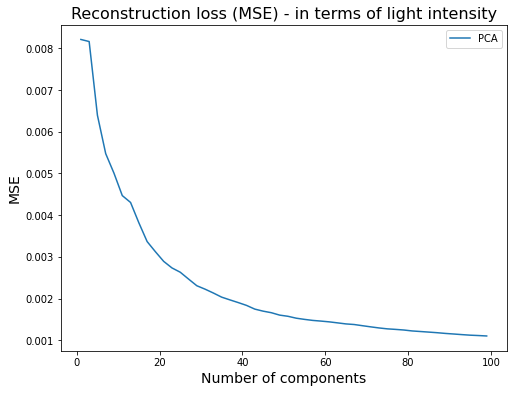

In [9]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot( np.array(n_comp_list_pca), np.array(pca_loss_list) , label = "PCA")

ax.legend()
ax.set_title("Reconstruction loss (MSE) - in terms of light intensity", fontsize = 16)
ax.set_ylabel("MSE", fontsize = 14)
ax.set_xlabel("Number of components", fontsize = 14)

In [10]:
pca_tau_loss = dict()
pca_tau_loss["loss"] = pca_loss_list
pca_tau_loss["ncomps"] = n_comp_list_pca

In [ ]:
dump_object("pca_tau", pca_results_dict)

# Signal reconstruction

In [11]:
random.seed(2324)
random_number = random.sample(range(val_df_pooled.shape[0]), 1, )
number_of_elements = 20

In [12]:
random_number

[275]

In [13]:
n_comp = 50

In [14]:
val_projected_pca, val_original_space_proj_pca, loss_pca = calculate_reconstr_loss_pca_tau(pca, val_df_pooled, n_comp,
                             rescale = False,
                             mean = data_dict["parameters"]["mean"],
                             std = data_dict["parameters"]["std"])

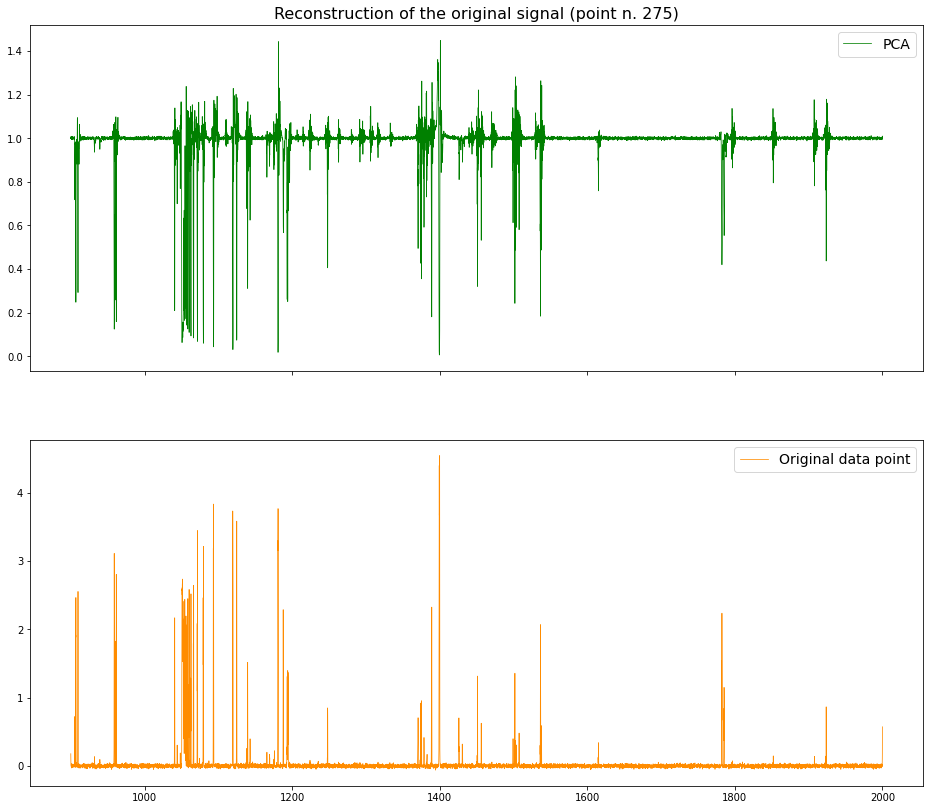

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex = True, figsize = (16, 14))

ax[0].plot(data_dict["wavelengths"], val_original_space_proj_pca[random_number,:][0], label = "PCA", linewidth = 0.75, color = "green")
ax[0].legend(fontsize = 14)

ax[1].plot(data_dict["wavelengths"], val_df_pooled[random_number,:][0], label = "Original data point", linewidth = 0.75, color = "darkorange")
ax[1].legend(fontsize = 14)

ax[0].set_title("Reconstruction of the original signal (point n. " + str(random_number[0]) + ")",
               fontsize = (16));